# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# LR Bayes sampler modules

##### Ver:: A2_V0.2.1
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrape from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
    - Dynamic degrees and hop-count for each pseudocell for maximum coverage
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


# ¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

In [2]:
models = {
    "pan_fetal_wget": "https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl",
    "YS_wget": "https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav",
}

adatas_dict = {
    "pan_fetal_wget": "https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad",
    "YS_wget": "https://app.cellatlas.io/yolk-sac/dataset/23/download",
    "YS_local": "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad",
    "YS_pre_agm": "https://app.cellatlas.io/yolk-sac/dataset/10/download",
    "FLIV_wget": "https://app.cellatlas.io/fetal-liver/dataset/1/download",
    "int_atlas_sub": "/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad",
    "int_atlas_full": "/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad",
}

# setup global params:
# Variable assignment
train_model = True
adata_key = "YS_local"  #'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local
data_merge = False  # read and merge multiple adata (useful, but keep false for now)
model_key = "new_example_model"  #'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local
# dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = False  #'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False  # should data be normalised?

# setup model parameters:
model_params = {
    "feat_use": "LVL3",
    "train_x_partition": "X_scvi",  # what partition was the data trained on?
    "penalty": "elasticnet",  # can be ["l1","l2","elasticnet"],
    "var_length": 7500,
    "batch_key": None,
    "sparcity": 0.5,  # If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
    "max_iter": 1000,  # Increase if experiencing max iter issues
    "thread_num": -1,
    "l1_ratio": 0.5,  # If using elasticnet without optimisation, this controls the ratio between l1 and l2)
    "partial_scale": False,  # should data be scaled in batches?
    "tune_hyper_params": True,  # Current implementation is very expensive, intentionally made rigid for now
    "batch_correction": False,
    "loss": "logloss",
    "sketch_tune": False,  # warning, do not use this if you are already sub-sampling
    # Stratified Bayes sampler kwargs
    "sample_data_knn": True,
    "straify_sampling": False,
    "knn_key": "neighbors",
    "sampling_rate": 0.1,  # Apply empirical bayes sampling weighted by knn?
    "weight_penalty": "laplacian_SGD_pagerank",  # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
    "iterations": 10,  # How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
    "representation_priority": 0.7,  # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
    "replace": True,  # Allows model to clone cells
    "equal_allocation": False,  # Forces model to create equal representation sets
    "resample_clones": True,
    "pl_label_entropy": False,
}

# Transductive learning workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Option 1: Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

- Representation priority represents a wighting factor used to recover rare-states. 
- Prioritisation factor, this will heavily bias the sampling of under-represented states

# Option 1.1: Using stratified sampling module with clones
- This module provides different attention metrics for local/global node importance measures
- Uses the prior distribution of cell-states as a prior for the sampling module
- Able to dynamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained
- Prioritisation parameter forces the retention of known-rare states if they are subsequently removed by the sampler

In [3]:
# setup model parameters:
model_params = {
    "feat_use": "LVL3",
    # Stratified Bayes sampler kwargs
    "sample_data_knn": True,
    "straify_sampling": True,  # Whether to stratify the sampling by "feat_use" or not
    "knn_key": "neighbors",
    "sampling_rate": 0.1,  # Apply empirical bayes sampling weighted by knn?
    "weight_penalty": "laplacian_SGD_pagerank",  # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
    "iterations": 10,  # How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
    "representation_priority": 0.7,  # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
    "replace": True,  # Allows model to clone cells
    "equal_allocation": False,  # Forces model to create equal representation sets
    "resample_clones": True,  # Reduce the number of clone cells where possible
    "pl_label_entropy": False,
}

Empirical bayes sampling option selected
You are using sampling with replacement, this allows the model to create clones of cells
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 748
Proceeding on to perform fine-tuning across full-batch


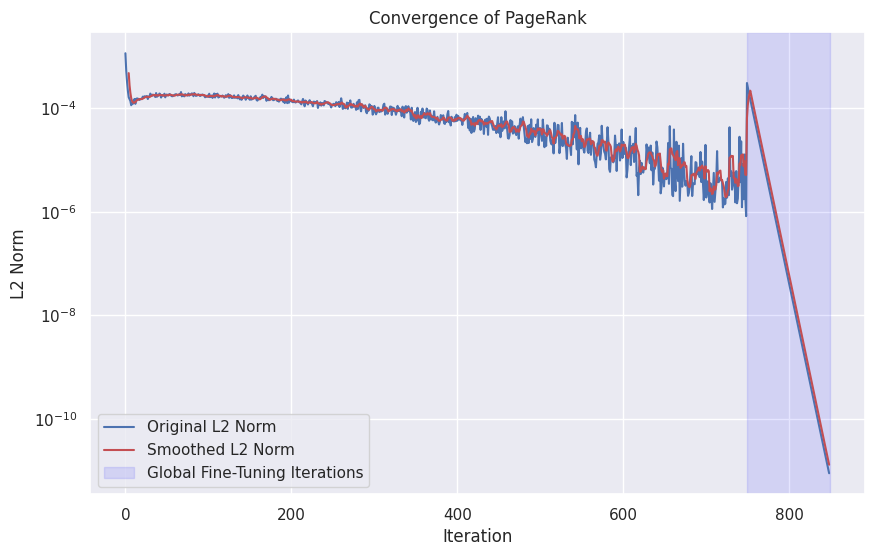

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


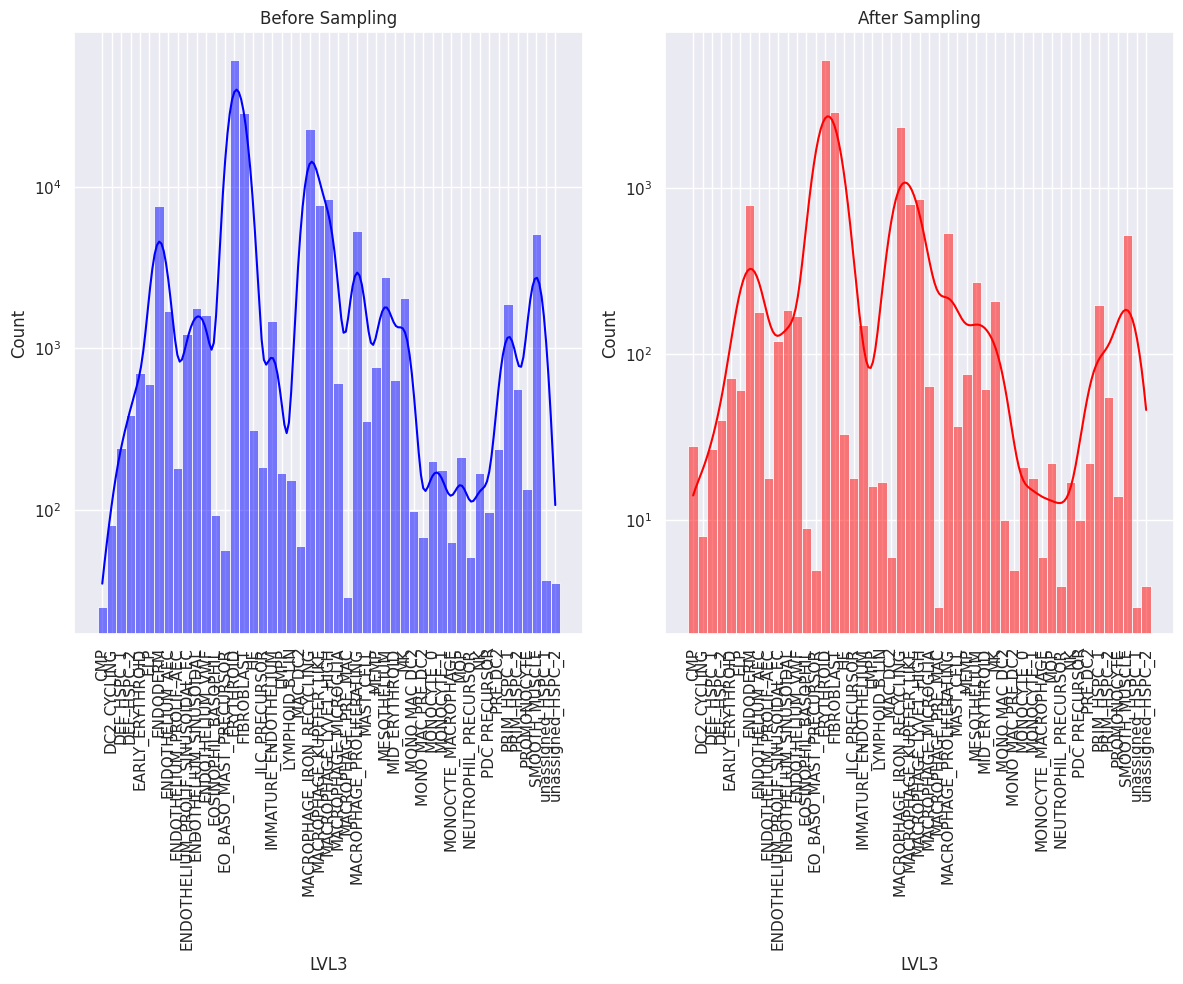

adata_loaded


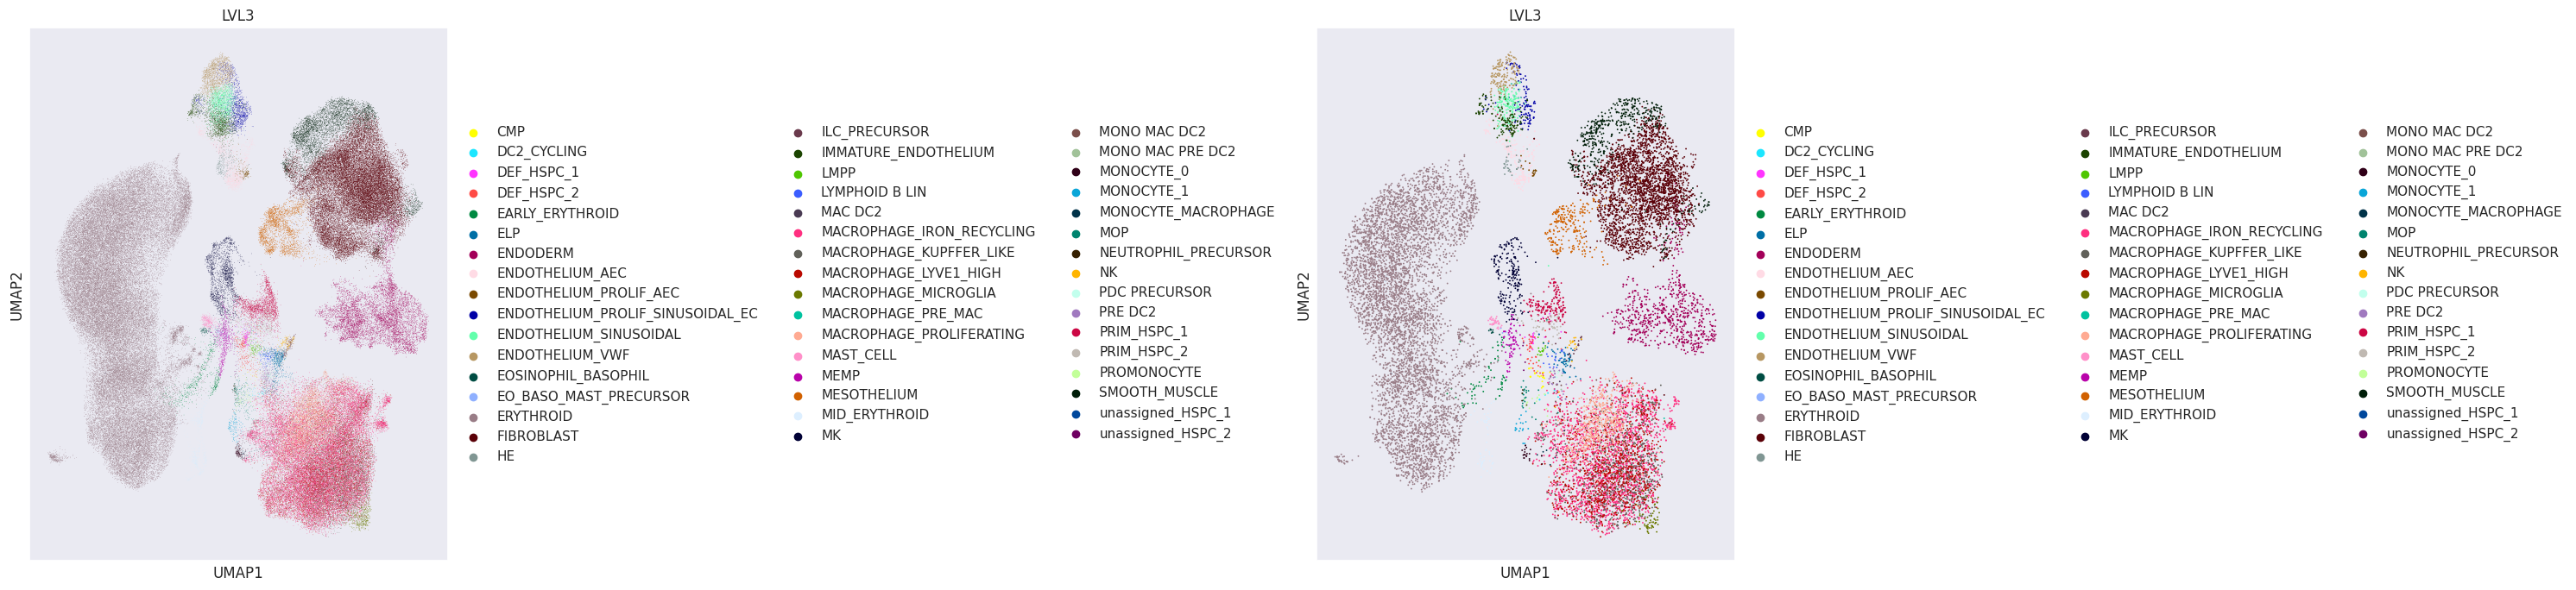

In [4]:
adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed="r")

if model_params["sample_data_knn"] != False:
    if model_params["straify_sampling"] == True:
        print("Empirical bayes sampling option selected")
        (
            adata_samp,
            indices,
            weights,
        ) = scent.empirical_bayes_balanced_stratified_KNN_sampling(
            adata, **model_params
        )
        scent.plot_sampling_metrics(adata, adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print("Attention-based non-straified sampling selected")
        adata_samp, sample_probs, weights = scent.Attention_based_KNN_sampling(
            adata, **model_params
        )
        scent.plot_sampling_metrics(adata, adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
print("adata_loaded")

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30, 7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params["feat_use"], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params["feat_use"], ax=axs[1], show=False)

# Display the plots
plt.tight_layout()
plt.show()

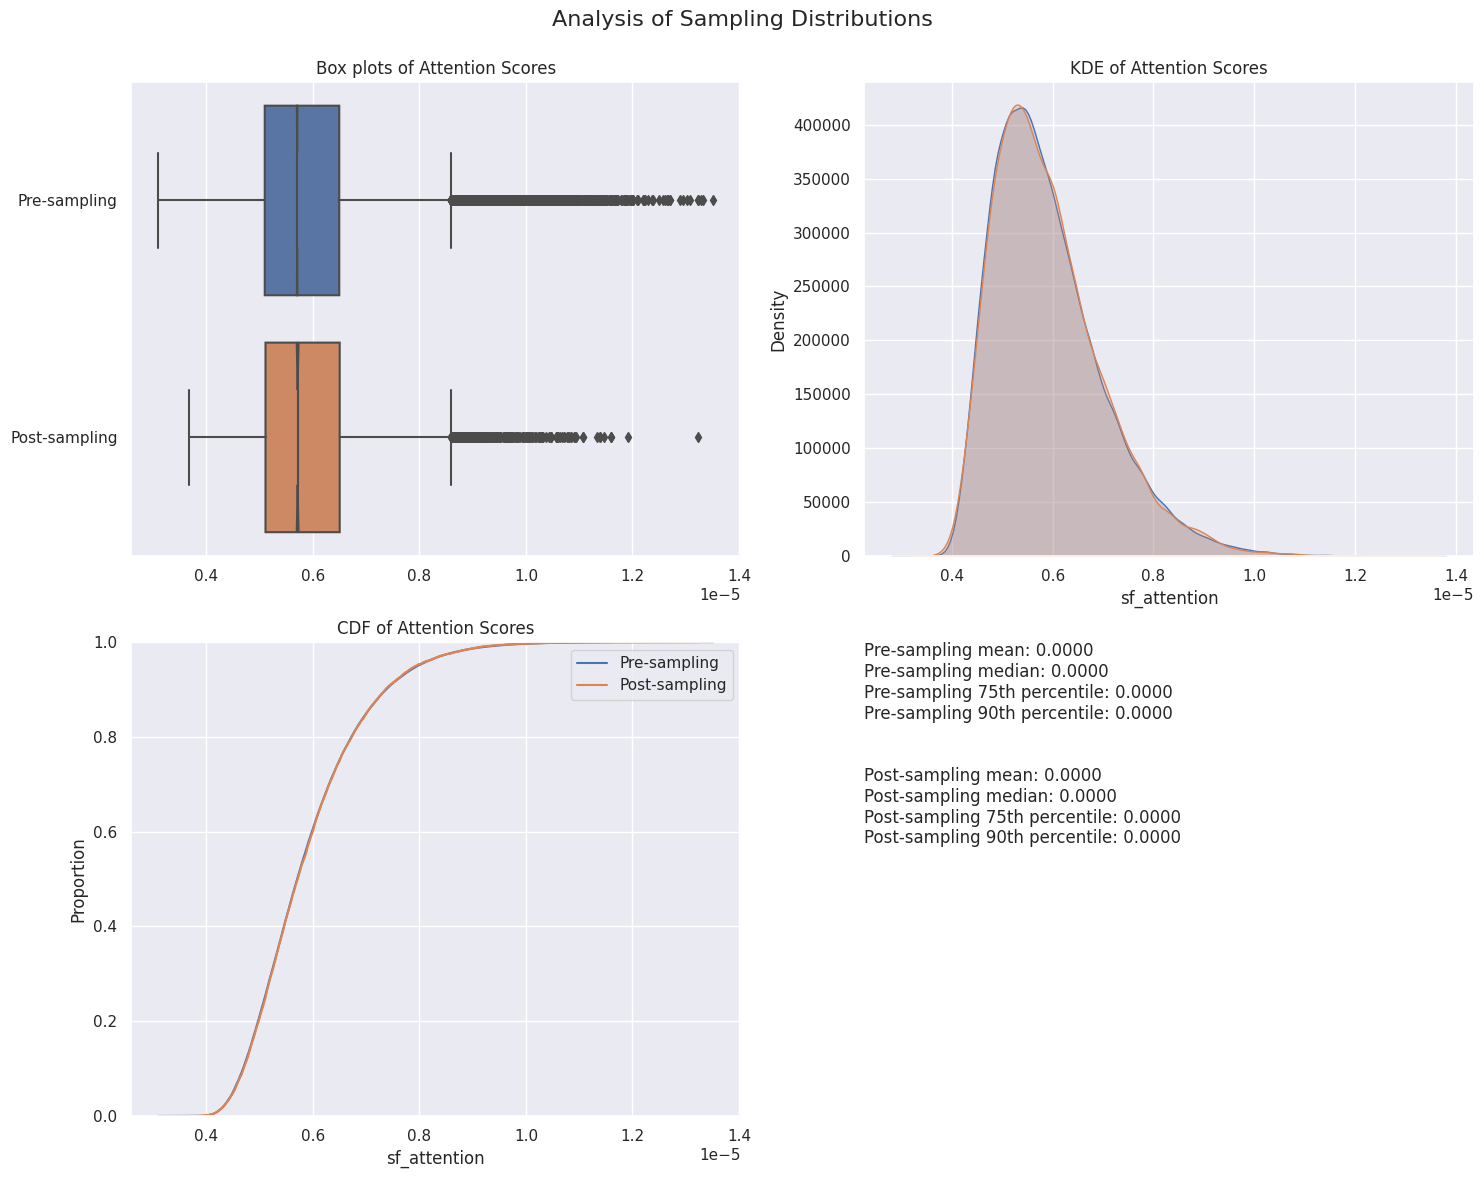

In [5]:
# Extract attention scores
pre_sample_scores = weights["all_weights"]
post_sample_scores = adata_samp.obs["sf_attention"]

scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Option 1.2:  Using stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior distribution of cell-states as a prior for the sampling module
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained
- Prioritisation parameter forces the retention of known-rare states if they are subsequently removed by the sampler

In [3]:
# setup model parameters:
model_params = {
    "feat_use": "LVL3",
    # Stratified Bayes sampler kwargs
    "sample_data_knn": True,
    "straify_sampling": True,  # Whether to stratify the sampling by "feat_use" or not
    "knn_key": "neighbors",
    "sampling_rate": 0.1,  # Apply empirical bayes sampling weighted by knn?
    "weight_penalty": "laplacian_SGD_pagerank",  # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
    "iterations": 10,  # How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
    "representation_priority": 0.7,  # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
    "replace": False,  # Allows model to clone cells
    "equal_allocation": False,  # Forces model to create equal representation sets
    "resample_clones": True,  # Reduce the number of clone cells where possible
    "pl_label_entropy": False,
}

Empirical bayes sampling option selected
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Converged at iteration 738
Proceeding on to perform fine-tuning across full-batch


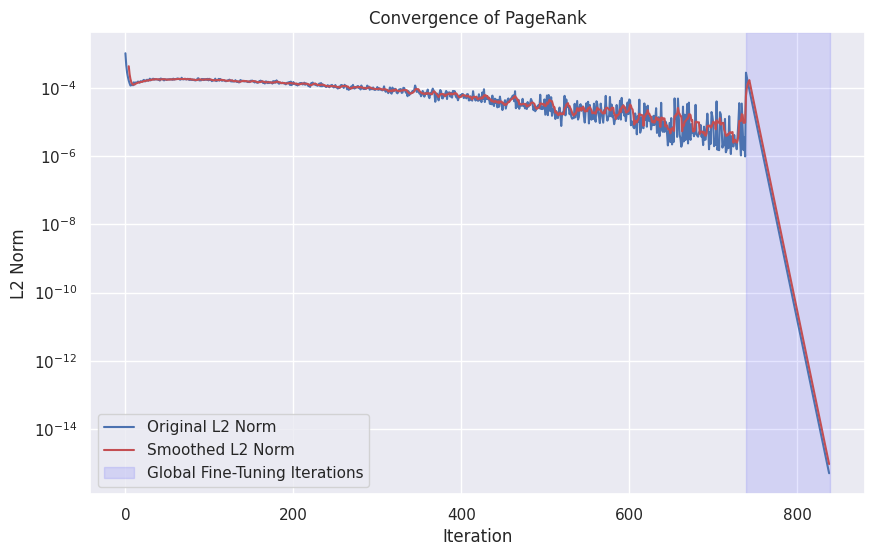

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Warning -- sampling for 0 without replacement failed, defaulting to taking all cells in this category
Warning -- sampling for 0 without replacement failed, defaulting to taking all cells in this category
Warning -- sampling for 0 without replacement failed, defaulting to taking all cells in this category
Warning -- sampling for 0 without replacement failed, defaulting to taking all cells in this category
Warning -- sampling for 0 without replacement failed, defaulting to taking all cells in this category
Warning -- sampling for 0 without replacement failed, defaulting

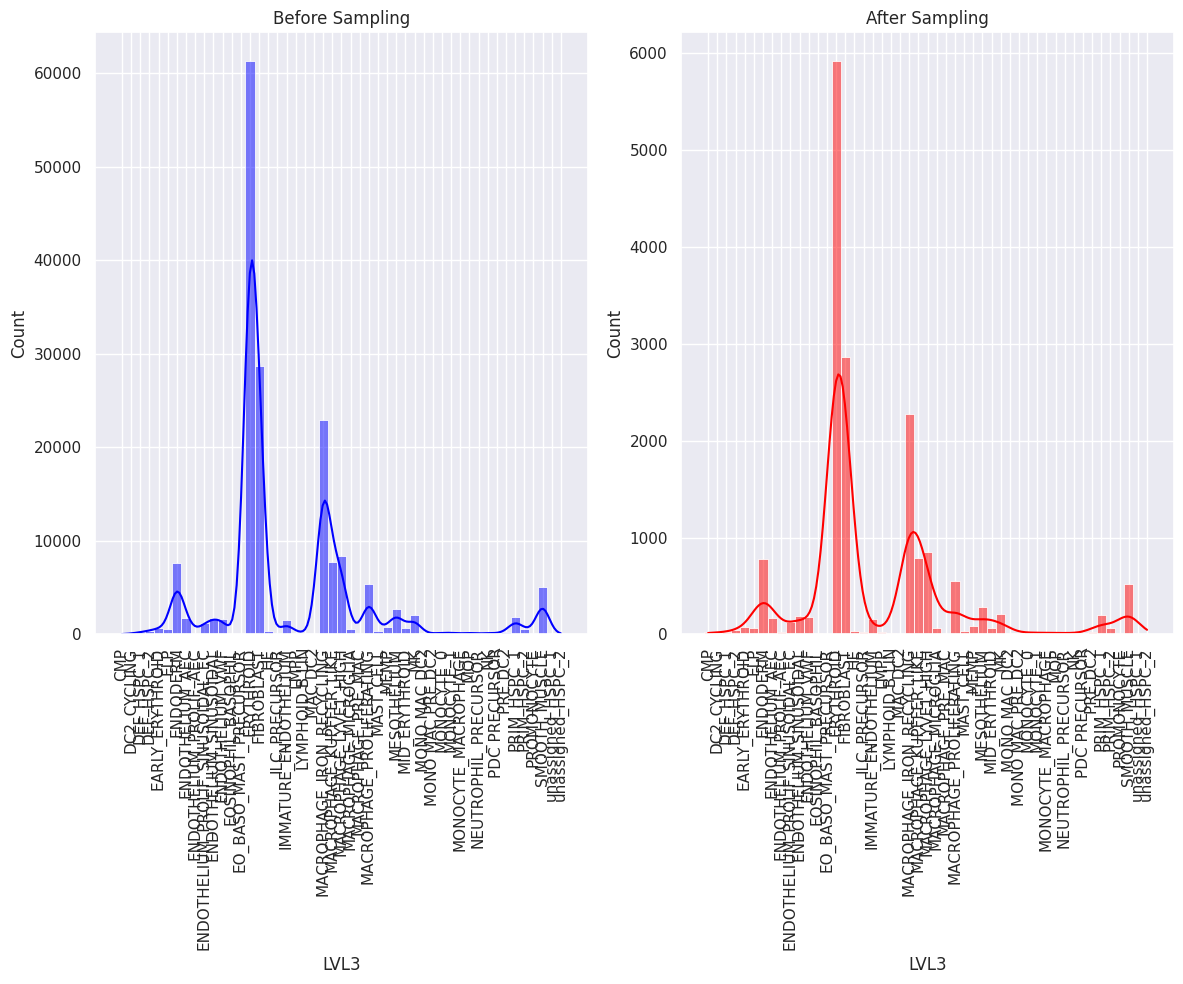

adata_loaded


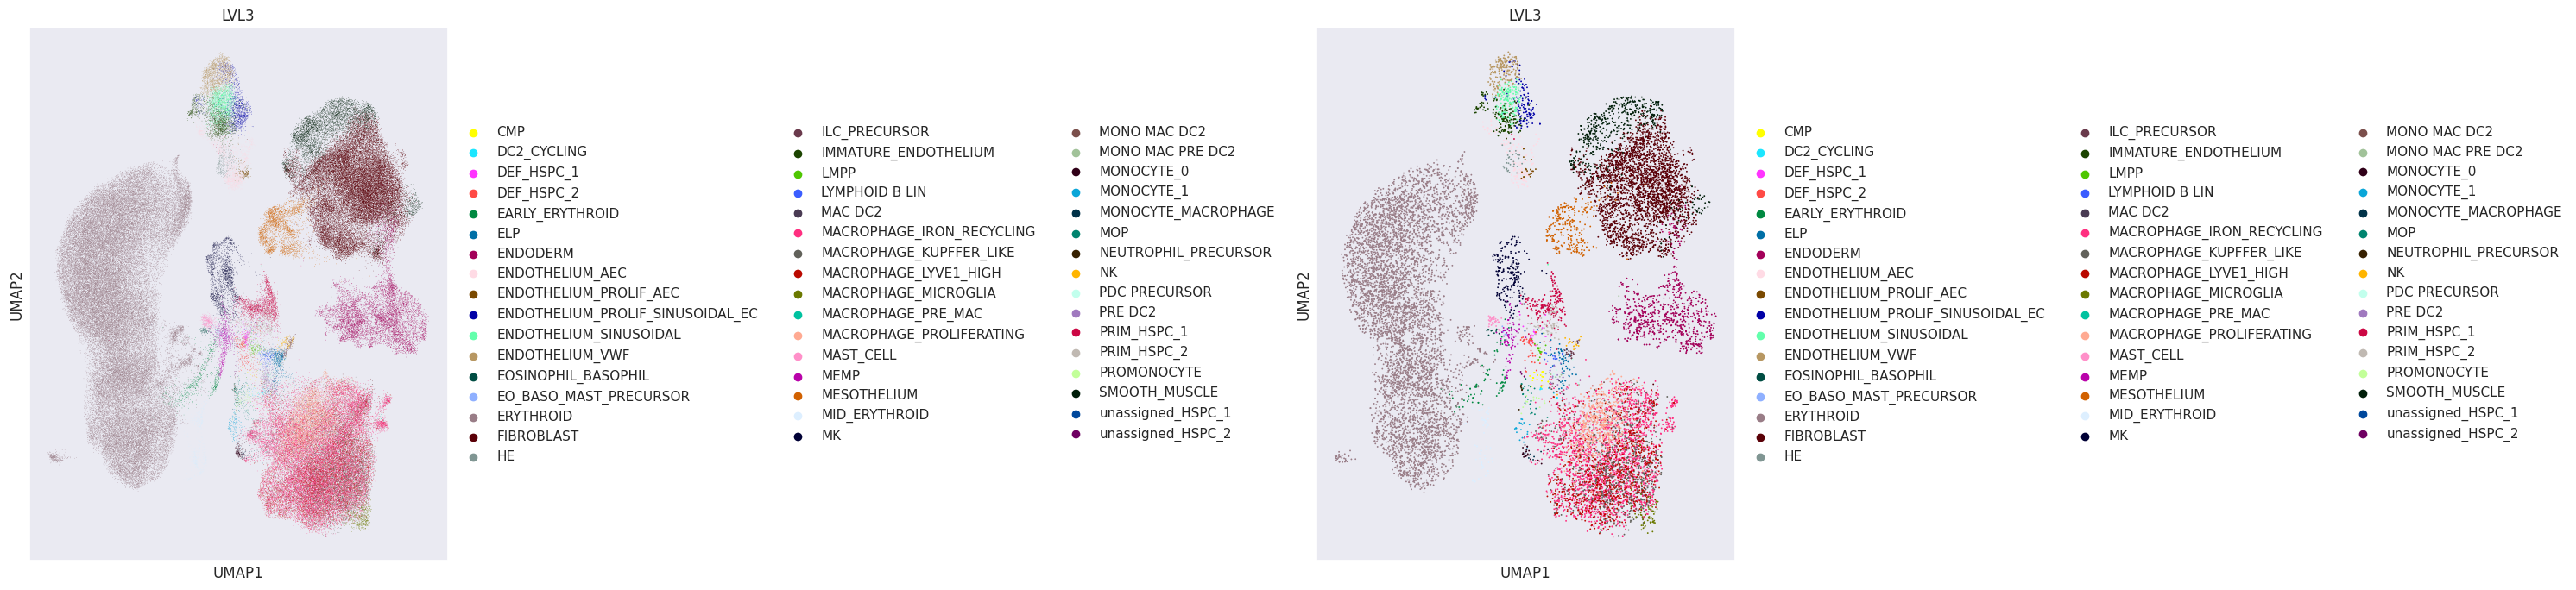

In [4]:
adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed="r")

if model_params["sample_data_knn"] != False:
    if model_params["straify_sampling"] == True:
        print("Empirical bayes sampling option selected")
        (
            adata_samp,
            indices,
            weights,
        ) = scent.empirical_bayes_balanced_stratified_KNN_sampling(
            adata, **model_params
        )
        scent.plot_sampling_metrics(adata, adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print("Attention-based non-straified sampling selected")
        adata_samp, sample_probs, weights = scent.Attention_based_KNN_sampling(
            adata, **model_params
        )
        scent.plot_sampling_metrics(adata, adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
print("adata_loaded")

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30, 7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params["feat_use"], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params["feat_use"], ax=axs[1], show=False)

# Display the plots
plt.tight_layout()
plt.show()

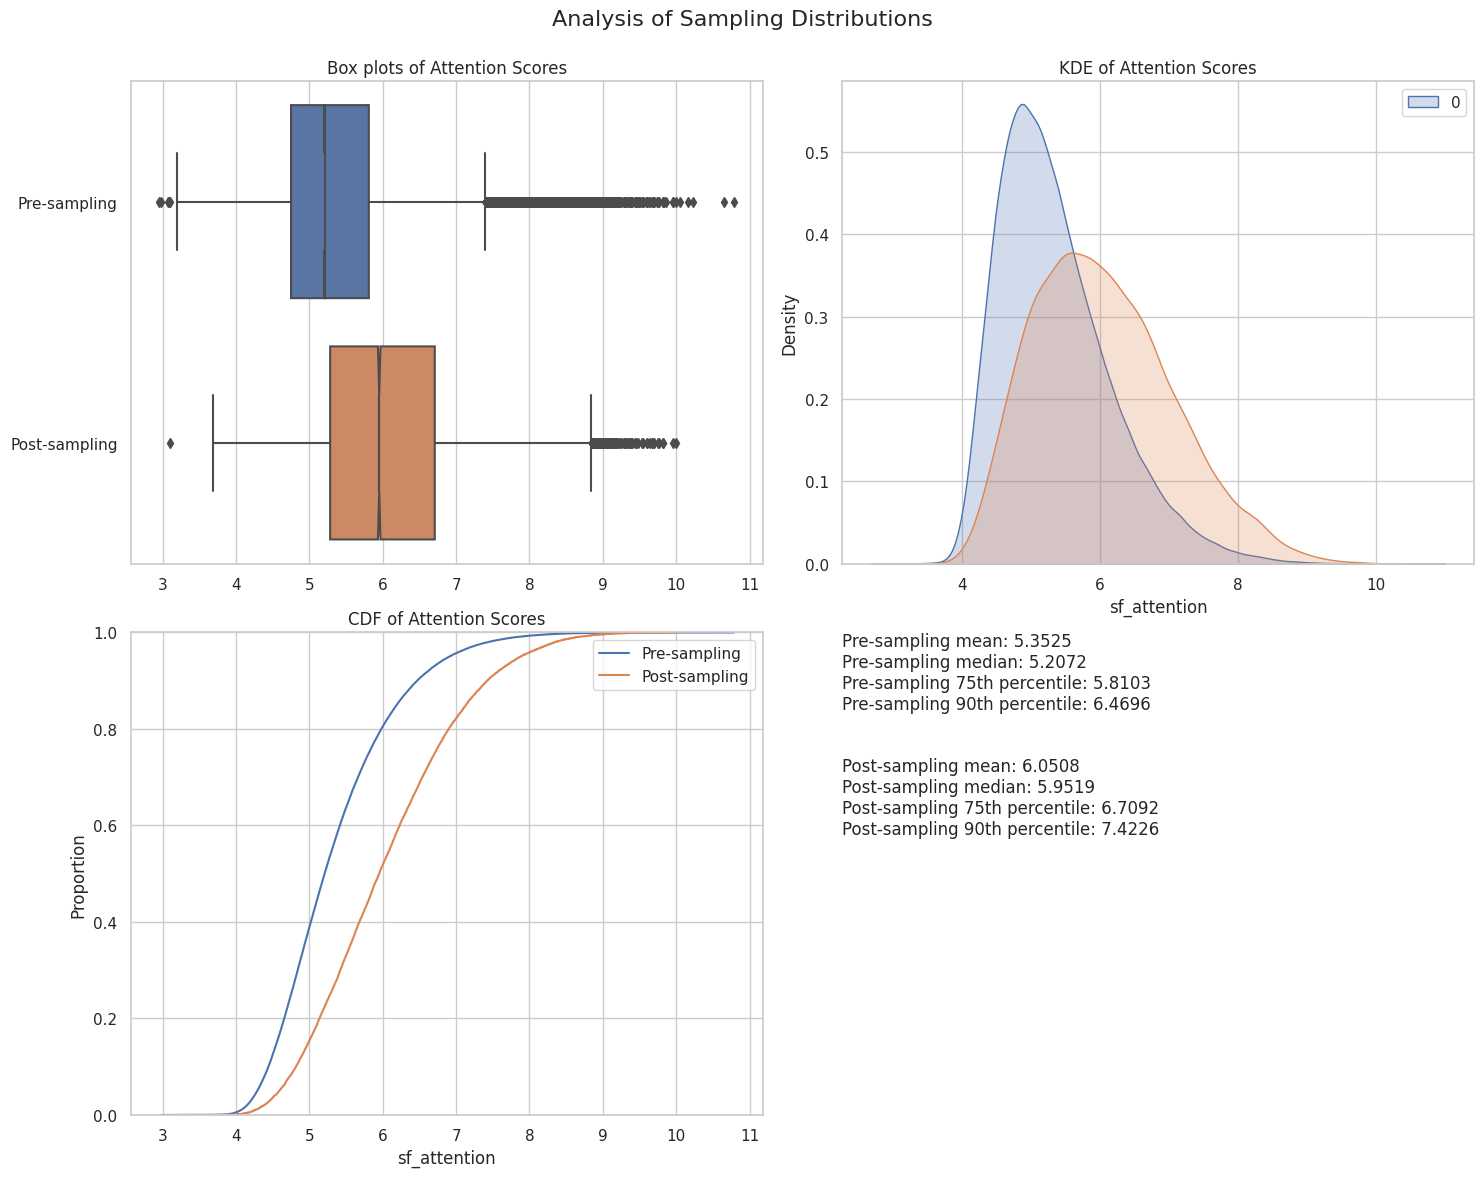

In [53]:
# Extract attention scores
pre_sample_scores = weights["all_weights"]
post_sample_scores = adata_samp.obs["sf_attention"]
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Option 2: Using non-stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior attention scores based on the established graph as priors
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained

In [5]:
# setup model parameters:
model_params = {
    # Stratified Bayes sampler kwargs
    "sample_data_knn": True,
    "straify_sampling": False,  # Whether to stratify the sampling by "feat_use" or not
    "knn_key": "neighbors",
    "sampling_rate": 0.1,  # Apply empirical bayes sampling weighted by knn?
    "weight_penalty": "laplacian_SGD_pagerank",  # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
    "iterations": 10,  # How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
    "representation_priority": 0.7,  # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
    "replace": False,  # Allows model to clone cells
    "equal_allocation": False,  # Forces model to create equal representation sets
    "resample_clones": True,  # Reduce the number of clone cells where possible
    "pl_label_entropy": False,
}

Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Converged at iteration 747
Proceeding on to perform fine-tuning across full-batch


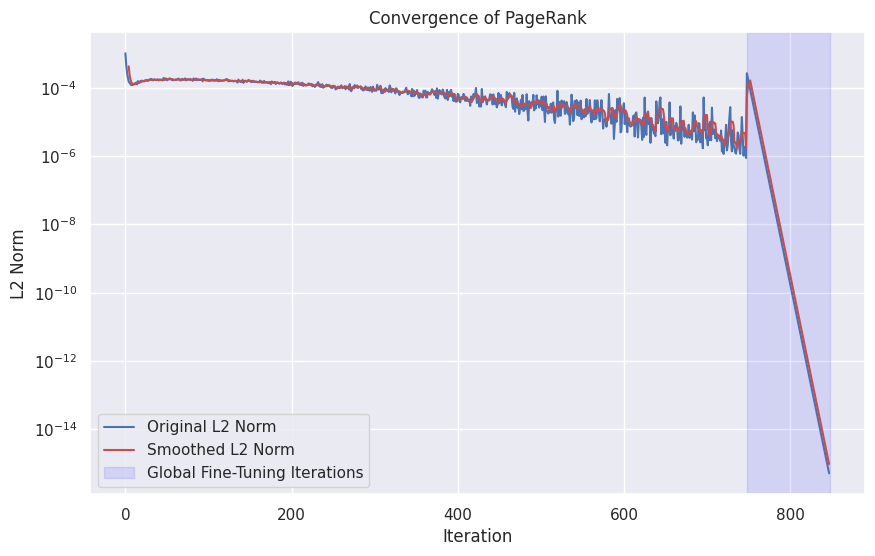

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


In [6]:
adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed="r")

if model_params["sample_data_knn"] != False:
    if model_params["straify_sampling"] == True:
        print("Empirical bayes sampling option selected")
        (
            adata_samp,
            indices,
            weights,
        ) = scent.empirical_bayes_balanced_stratified_KNN_sampling(
            adata, **model_params
        )
        #         scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print("Attention-based non-straified sampling selected")
        adata_samp, sample_probs, weights = scent.Attention_based_KNN_sampling(
            adata, **model_params
        )
        #        scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
print("adata_loaded")

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

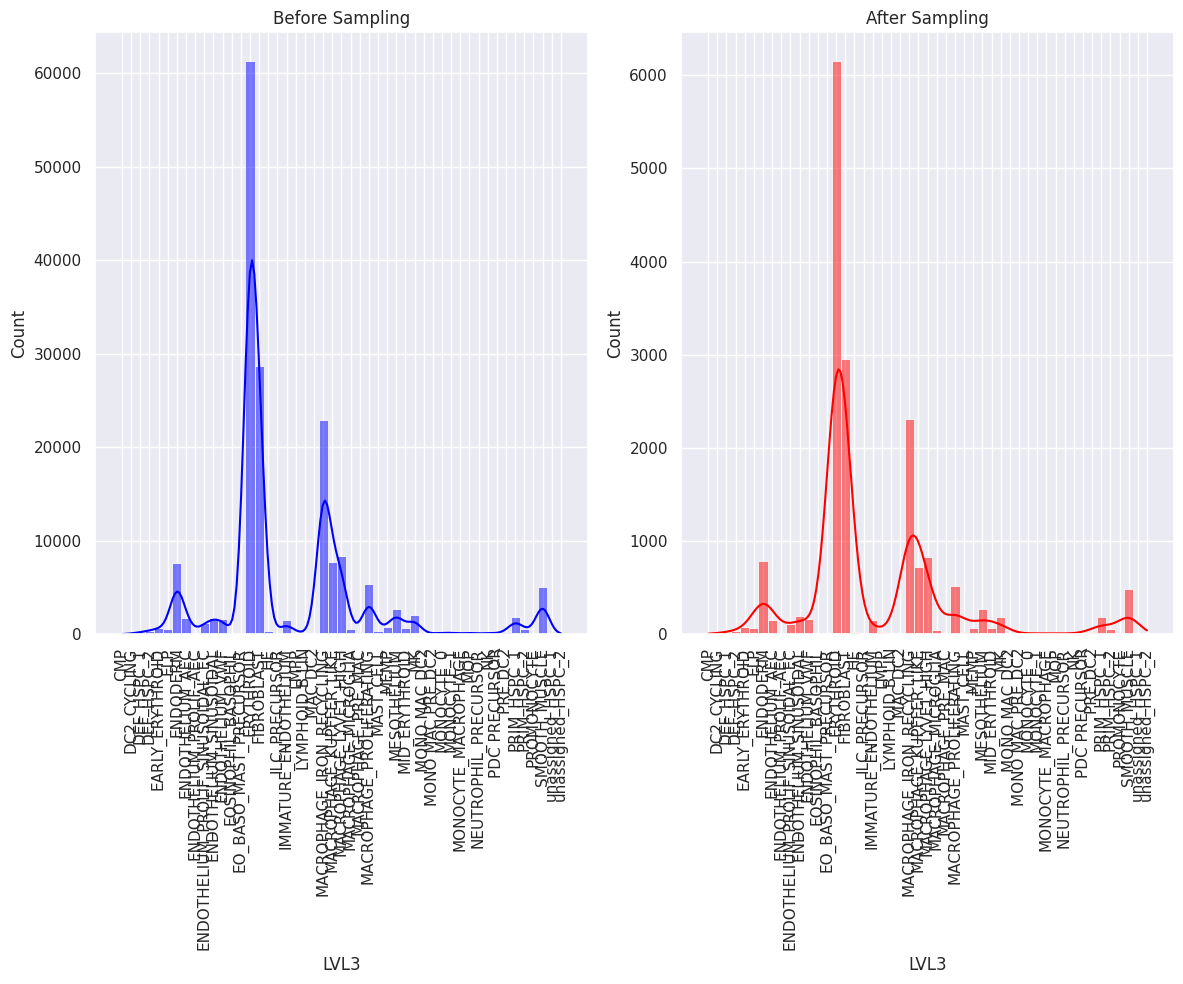

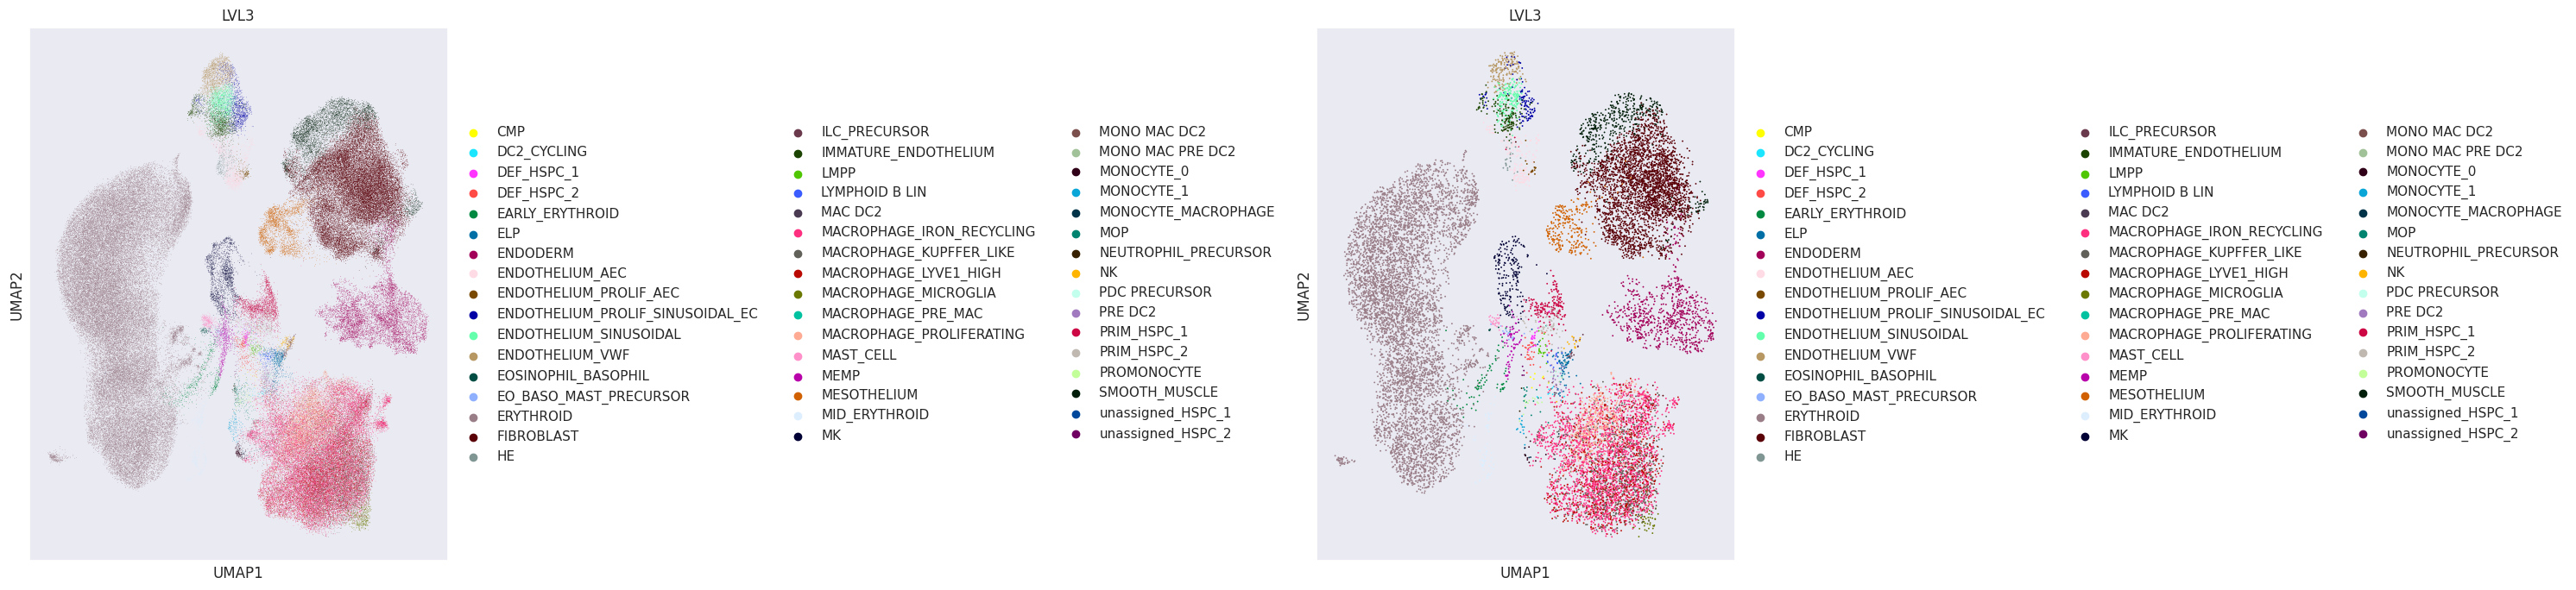

In [7]:
model_params["feat_use"] = "LVL3"
scent.plot_sampling_metrics(adata, adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30, 7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params["feat_use"], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params["feat_use"], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

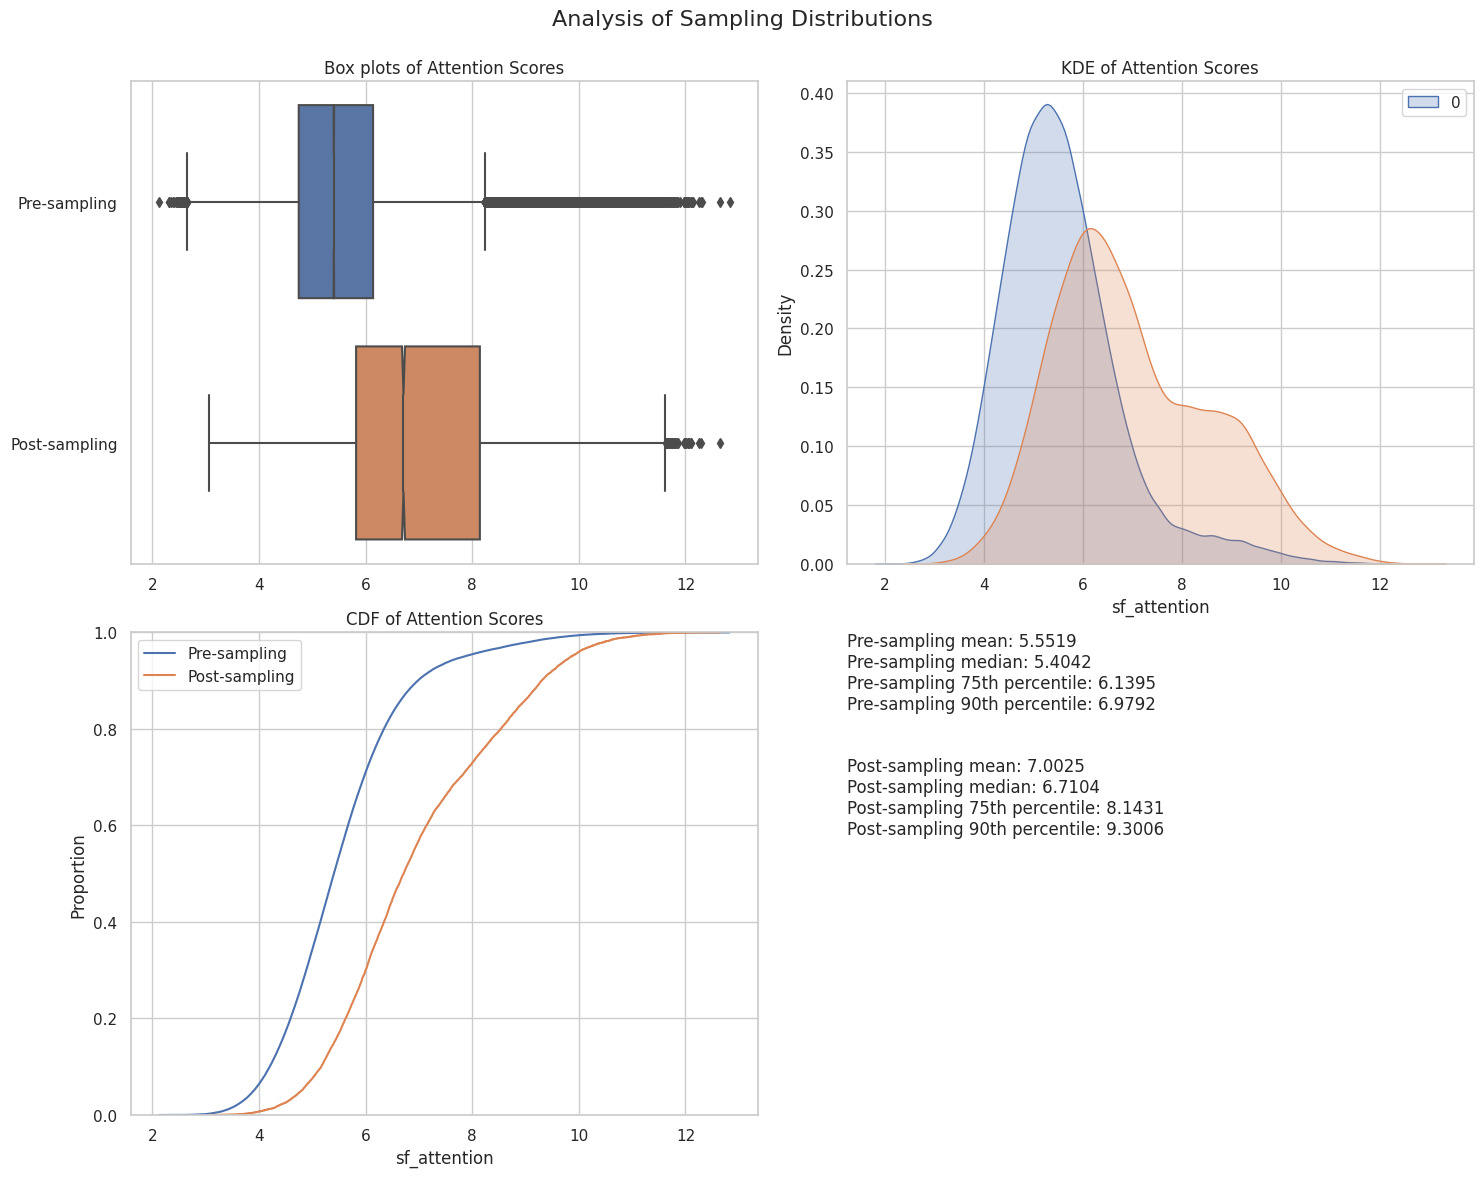

In [56]:
pre_sample_scores = weights["all_weights"]
post_sample_scores = adata_samp.obs["sf_attention"]
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)